## Inspecting what Cis-Regulatory Features a Model Has Learned

`tangermeme` was created for the purpose of helping researchers use sequence-based machine learning models after training. An important question that most people have after training is "what did my model learn?" Specifically, one is likely interested in the motifs that the model has picked up on. There are currently two main ways that researchers do this right now: (1) use a de novo motif discovery method like TF-MoDISco, or (2) manually inspect many loci and cross-reference the spans of high attribution with an external database like JASPAR using a tool like TOMTOM. However, TF-MoDISco can be slow when all you want to know is, at a high level, "what motifs are present here?" (and conversely, what motifs *are not* being used), and doing anything manually is a pain.

In this vignette, we will explore the functionality in `tangermeme` for uncovering what these sequence-based model have learned. There are pros and cons to each method, so keep those in mind when deciding what to do.

#### The Model

In this vignette, we will be using a BPNet model that has been trained to predict GATA2 profiles. Although this model can make predictions for the total counts in a region as well as the basepair mapped profiles, we will only be using the total counts here to make analyses easier. Because the BPNet model expects a control track in addition to the sequence, we will use a wrapper that always passes in an all-zeroes control to factor out that influence. Basically, just view this as a model that takes in genome sequence and outputs GATA2 counts.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy
import torch

from bpnetlite.bpnet import CountWrapper, ControlWrapper

bpnet = CountWrapper(ControlWrapper(torch.load("../tutorials/gata2.bpnet.torch")))

#### The Methods

tl;dr? Skip to the flow-chart below.

Now that we have a model we want to inspect, we have to answer a few questions. Most importantly: <i>do we want to do truly de novo motif discovery or not?</i> If we do, we should use TF-MoDISco. But, frequently, we do not actually want to do complete de novo motif discovery. Rather, we may have a set of motifs that we are specifically interested in and we want to quickly see whether the model has learned any of them. This set of motifs can be quite large -- it can even be all of JASPAR! De novo motif discovery can be an unbiased way of discovering what the model has learned but it can be quite time intensive for large data sets and, in my experience, researchers want a quick answer to "did my model predicting GATA binding actually learn a GATA motif?" and plan to later on do de novo motif discovery (say, running it overnight after telling your supervisor that the model seems to work). 

Next, we need to decide <i>if we have a set of sequences</i>. Frequently this answer is just "yes, I have a set of peaks". However, keep in mind that performing your analyses with respect to a set of sequences is not always the right thing to do either. Biological sequences are extremely structured in terms of cis-regulation and so your results may be convoluted by what sets of motifs appear together. 

If we do not have a set of sequences, or we want to calculate model response in a manner agnostic to the distribution of cis-regulatory elements in the genome, then we need to do a "marginalization." Here, we insert each motif from our external motif database into background sequences and consider model predictions before and after. This idea can also be extended to attributions, where we look at model attributions before and after substituting in each motif. For more details, see the tutorial on marginalization.

Now, if we do have sequences that we want to consider (e.g., all peaks genome-wide, all promoter elements, distal enhancer regions, etc.) there are two options to consider: identify short spans of high-attribution ("seqlets") de novo and then map them to your database (seqlet calling + TOMTOM), or identify motif hits based on sequence similarity alone and then threshold on attribution score (FIMO + attribution threshold). You can read more on these methods in the tutorial on annotations. Identifying seqlets de novo allows for better identification of the actual regions the model cares about but the motif library being used matters a great deal because variance in the seqlet sequence can cause the best motif match to change when many motifs have similar motif composition. In contrast, FIMO will find good sequence hits for your motif database but if the seqlet does not actually align with that hit, you may be assigning some attribution incorrectly to a motif that is actually not relevant.

Here is a helpful flow-chart to help you navigate which method to use.

<img src=imgs/tangermeme.learn.png>

#### TF-MoDISco

TF-MoDISco is a stand-alone tool that is not a part of `tangermeme`. You can find instructions for how to use it at https://github.com/jmschrei/tfmodisco-lite. As a short description, you will need to calculate attributions for your region set using `tangermeme` and then either use the built-in Python function (https://github.com/jmschrei/tfmodisco-lite/blob/main/modiscolite/tfmodisco.py#L260) or save the attributions and sequences and use the command-line tool.

#### Marginalization (Predictions)

Marginalization is the process of substituting in a motif and observing the change in model output before and after the substitution. Usually, this substitution is done into a background region so that one can estimate the "marginal" effect that each motif has on model predictions in isolation, and this value is averaged over many background sequencces.

An important complication in using marginalizations is the choice of background. <b><i>Uniformly generated random background sequences are likely much higher in GC content than the genome these models were trained on</i></b> and so they may not be the best choice, although they are very convenient to use. The best choice is usually to use regions of the genome that are known to not exhibit the activity you care about but have similar GC content, e.g., regions that are not peaks, regions that are not accessible, non-gene body non-promoter regions, etc. The second best choice is to use randomly generated sequences with proportions of each character derived from the genome. As a reference: for `chr1` after excluding N's these proportions are `[0.2910, 0.2085, 0.2087, 0.2918]`. When prototyping, it is okay to use uniformly randomly generated sequences, but make sure to switch before presenting your results. <i><b>Models can be very sensitive to local GC content and so when you substitute a motif with a very different content you may get a "mirage" that is driven entirely by this local change in GC content.</i></b>

In general, more background sequences is better as long as you have the compute for it but this betterness drops off quickly after around 100 sequences. 

In [2]:
from tangermeme.utils import random_one_hot

X = random_one_hot((100, 4, 2114), probs=numpy.array([[0.2910, 0.2085, 0.2087, 0.2918]])).float()
X.mean(dim=-1)[:5]

tensor([[0.2919, 0.2167, 0.2039, 0.2876],
        [0.2805, 0.2029, 0.2152, 0.3013],
        [0.2862, 0.2124, 0.2010, 0.3004],
        [0.2838, 0.2219, 0.2058, 0.2886],
        [0.2819, 0.2242, 0.2020, 0.2919]])

Now, we can load up a few motifs to consider (and make sure to put the GATA motif in as well). In practice, you want to be comprehensive about this, but for this tutorial we will only do a few. We will use the JASPAR database for this.

In [3]:
from tangermeme.io import read_meme

motifs = read_meme("../tutorials/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt", n_motifs=5)
motifs['MA0036.3 GATA2'] = read_meme("../tutorials/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt")["MA0036.3 GATA2"]

Then, we can do the marginalization.

In [4]:
from tangermeme.marginalize import marginalize
from tangermeme.utils import pwm_consensus

for name, pwm in motifs.items():
    consensus = pwm_consensus(pwm).unsqueeze(0)
    y_before, y_after = marginalize(bpnet, X, consensus)
    delta = (y_after - y_before).mean().item()
    print(name, delta)

MA0004.1 Arnt 0.007374629843980074
MA0006.1 Ahr::Arnt 0.005128492135554552
MA0019.1 Ddit3::Cebpa -0.0021654844749718904
MA0029.1 Mecom 0.17749778926372528
MA0030.1 FOXF2 -0.007398463319987059
MA0036.3 GATA2 0.11949684470891953


Looks like the BPNet model makes larger count predictions when the GATA2 motif has been inserted. But.. it seems to make even larger count predictions when using this "Mecom" motif. Is this a mistake? Let's take a look at what those PWMs are using the `plot_pwm` function, which takes in a PWM where each column is a probability vector and plots the information content of the PWM and its reverse complement.

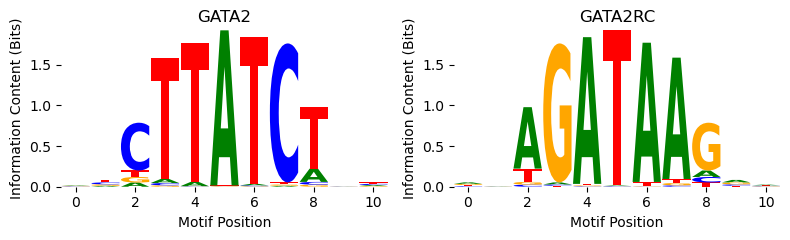

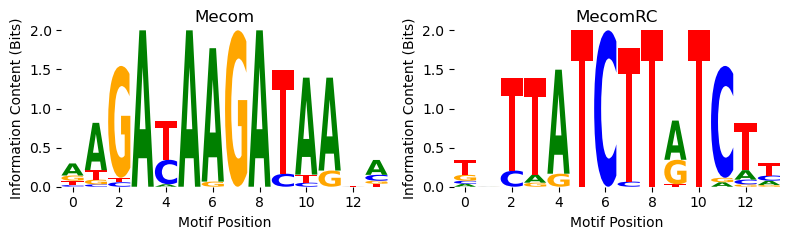

In [5]:
from tangermeme.plot import plot_pwm

plot_pwm(motifs['MA0036.3 GATA2'], "GATA2")
plot_pwm(motifs["MA0029.1 Mecom"], "Mecom")

Looks like the Mecom motif is just two GATAA motifs next to each other. Because the core GATAA is flanked by a G at the end and an A at the beginning, the beginning of one motif can actually snap in to the end of the second motif. Regardless, the reason the model is responding to the Mecom motif is likely because it's actually just responding to the GATA2 motif and Mecom is two of those.

#### Marginalization (Attribution)

Rather than looking at the difference in predictions before and after substituting in a motif, we can look at the difference in <i>attributions</i> at each position in the input. You can read more about this in the marginalization tutorial, but all you need to do is pass in the `deep_lift_shap` function (or whatever other function you would like to use) to the `marginalize` function. A small difference in processing these results is that, because you get attribution values for each input position rather than just a single output value like with the prediction function, you may want to limit the window you consider to just surrounding the motif of interest. Further, doing this in attribution space will likely be much slower than in prediction space if tyou use `deep_lift_shap` because you need to do a number of shuffles for each of the examples you are marginalizing over.

In [6]:
from tangermeme.deep_lift_shap import deep_lift_shap

for name, pwm in motifs.items():
    consensus = pwm_consensus(pwm).unsqueeze(0)

    n = consensus.shape[1] // 2 + 1
    s, e = 2114 // 2 - n, 2114 // 2 + n
    
    y_before, y_after = marginalize(bpnet, X, consensus, func=deep_lift_shap)
    y_before = y_before[:, :, s:e] * X[:, :, s:e]
    y_after = y_after[:, :, s:e] * X[:, :, s:e]
    
    delta = (y_after - y_before).mean().item()
    print(name, delta)

MA0004.1 Arnt 3.4735185181489214e-05
MA0006.1 Ahr::Arnt 2.23364113480784e-05
MA0019.1 Ddit3::Cebpa 1.0883775757974945e-05
MA0029.1 Mecom 0.0013928902335464954
MA0030.1 FOXF2 3.253892373322742e-06
MA0036.3 GATA2 0.0010769471991807222


Likewise, we are seeing orders of magnitude higher attribution signal for the GATA motifs than for the other ones. Further, it looks like taking the average across the motif length has caused the two to have similar scores because one is just two GATA motifs in a row. 

#### Seqlet Calling + TOMTOM

Now, let us take a look at method that relies on actual genomic sequence. As mentioned previously, sometimes using actual genomic sequence can convolute your results because many motifs can be present at each sequence. However, sometimes this is actually want you want because either (1) you want to quantify cis-regulation in actual genomic sequences or (2) you want to evaluate the model in the same setting it was trained, among other reasons.

This first method involves first identifying short spans of high attribution called "seqlets" and then mapping the sequences of these seqets to a database. Importantly, this first step is entirely attribution-based and so focuses on what the model has learned and the second step is entirely sequence-based and so focuses entirely on prior knowledge. Please see the seqlets tutorial for more information about the seqlet calling algorithm, and the annotations tutorial for more about using TOMTOM for seqlet annotation.

First, we should load up some sequences. These will be GATA2 peaks from the ENCODE portal. You can download the file from `https://www.encodeproject.org/files/ENCFF497ISV/@@download/ENCFF497ISV.bed.gz`. You will also need the human genome hg38. 

In [7]:
import pandas
from tangermeme.io import extract_loci

peaks = pandas.read_csv("ENCFF497ISV.bed.gz", sep="\t", usecols=(0, 1, 2), names=['chrom', 'start', 'end'])
X = extract_loci(peaks, "../tutorials/hg38.fa", verbose=True, in_window=2114).float()
X = X[X.sum(dim=(1, 2)) == X.shape[-1]]
X.shape

Loading Loci: 100%|████████████████████████████████████████████████████████████| 11447/11447 [00:00<00:00, 12315.26it/s]


torch.Size([11443, 4, 2114])

Then, because seqlets are called on attributions, we will calculate attributions for each sequence.

In [8]:
X_attr = deep_lift_shap(bpnet, X, device='cuda', batch_size=128, n_shuffles=20, random_state=0, warning_threshold=0.1, verbose=True)

100%|█████████████████████████████████████████████████████████████████████████| 228860/228860 [03:30<00:00, 1085.63it/s]


Now we need to call seqlets using the `recursive_seqlets` function. This is explained in more detail in the seqlets tutorial, but the only important parameters to the function are a p-value threshold (default is 0.01) and an `additional_flanks` value for how far out to extend the seqlets after they are identified (this can help include flanking regions that may be important).

In [9]:
from tangermeme.seqlet import recursive_seqlets

seqlets = recursive_seqlets(X_attr.sum(dim=1), additional_flanks=1)
seqlets.head()

,example_idx,start,end,attribution,p-value
0,616,1001,1007,-0.029226,4.289254e-07
1,3470,1065,1075,-0.042681,1.475572e-06
2,15,1035,1044,0.390759,1.520215e-06
3,4568,1089,1096,-0.034386,1.572707e-06
4,2141,1084,1094,0.403397,1.634249e-06


After calling the seqlets we can now annotate them by using TOMTOM to match the sequence of each seqlet with the PWMs in a motif database using the `annotate_seqlets` function. There are a few optional parameters but this function takes in the sequences, seqlets, and a motif database, and returns the index of the best motif match(es). You can read more about it in the annotations tutorial.

In [10]:
from tangermeme.annotate import annotate_seqlets

motif_idxs = annotate_seqlets(X, seqlets, "../tutorials/motifs.meme.txt")[0][:, 0]

Finally, we can count the annotations. This will return a tensor of size `(n_sequences, n_motifs)` where the value is the count of the number of times each annotation (motifs, in our case) appear in each sequencce.

In [11]:
from tangermeme.annotate import count_annotations

y = count_annotations((seqlets['example_idx'], motif_idxs))
y.shape

torch.Size([11443, 2193])

We can sum this across all sequences and show the motifs with the top five number of counts.

In [12]:
motifs = read_meme("../tutorials/motifs.meme.txt")
motif_names = numpy.array(list(motifs.keys()))

y_sum = y.sum(dim=0)
idxs = torch.flip(torch.argsort(y_sum), dims=(-1,))

names = motif_names[idxs[:5]]
names, y_sum[idxs[:5]]

(array(['Gata1_MA0035.3', 'Gata4_MA0482.1', 'Mecom_MA0029.1',
        'GATA3_MA0037.3', 'CPEB1_RRM_1'], dtype='<U29'),
 tensor([8435, 2183, 1515, 1454,  541]))

Unsurprisingly, we get a bunch of GATA motifs as well as the Mecom motif again. However, this shows a weakness in the seqlet calling + TOMTOM approach. If you have many redundant motifs, subtle variation in seqlet sequence may cause the seqlet to be mapped to a different (but highly similar) motif. If there are many similar motifs, this can split the count several ways and potentially even cause a motif that is much rarer but still recognized by the model to be the highest ranking motif. Basically, if you are not using a motif set that is internally very dissimilar (e.g., a deduped or merged motif set), you should be wary of using count alone. 

Unrelated to the final counts, the annotations generated by this process can help us visualize sequences better. We can use the seqlet calls as annotations to highlight in our plots, and the name of the motif as the label.

/tmp/ipykernel_1499319/495163197.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqlets_['example_idx'] = motif_names[motif_idxs[idxs]]


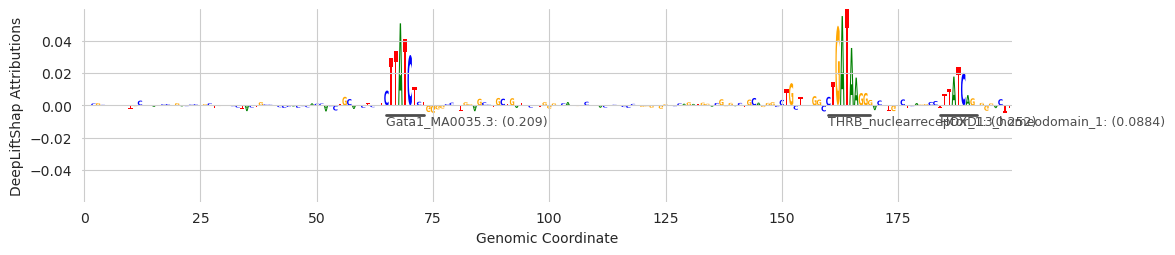

/tmp/ipykernel_1499319/495163197.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqlets_['example_idx'] = motif_names[motif_idxs[idxs]]


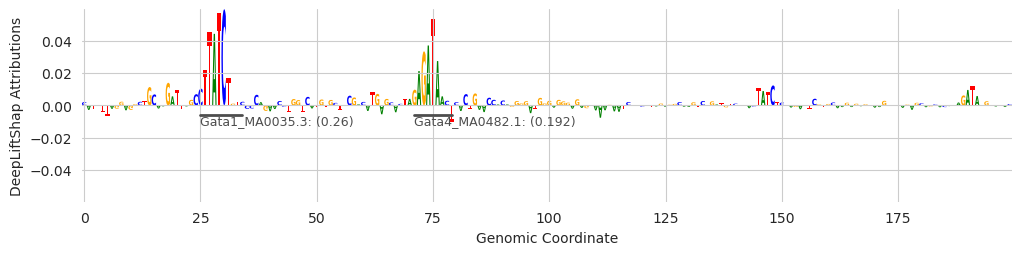

/tmp/ipykernel_1499319/495163197.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqlets_['example_idx'] = motif_names[motif_idxs[idxs]]


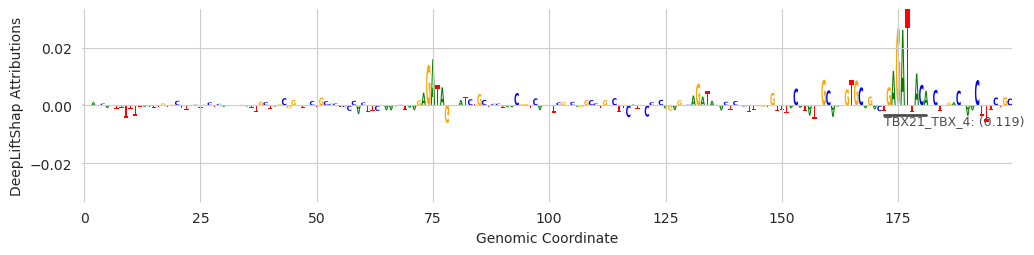

/tmp/ipykernel_1499319/495163197.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqlets_['example_idx'] = motif_names[motif_idxs[idxs]]


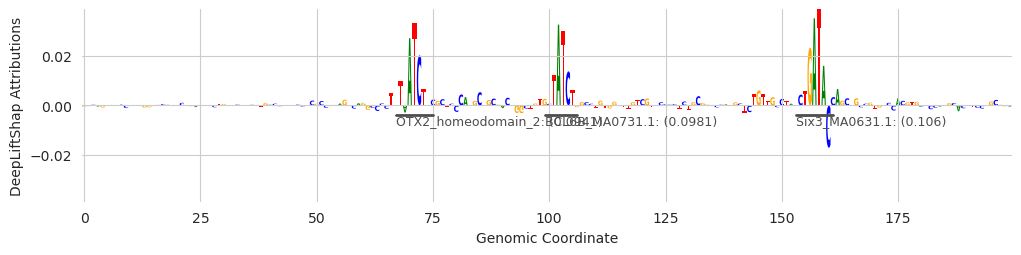

In [13]:
from tangermeme.plot import plot_logo
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')


for idx in range(10, 14):
    idxs = seqlets['example_idx'] == idx
    
    seqlets_ = seqlets[idxs]
    seqlets_['example_idx'] = motif_names[motif_idxs[idxs]]
    seqlets_ = seqlets_[seqlets_['attribution'] > 0]
    
    plt.figure(figsize=(12, 2.5))
    ax = plt.subplot(111)
    plot_logo(X_attr[idx], ax=ax, start=950, end=1150, annotations=seqlets_, score_key='attribution')
    plt.ylabel("DeepLiftShap Attributions")
    plt.xlabel("Genomic Coordinate")
    plt.show()

These examples provide some insight into the underlying process. The first two examples show that GATA has been found. But the first, third, and fourth, show that sometimes seqlets that are close but not identical to the GATA motif can be assigned to a slightly different one. Genome-wide, the noise gets filtered out because only a few seqlets will map to these other motifs, but individual examples might be challenging to interpret. An alternate strategy, which I go too deeply into here, is to get the top N annotations for each seqlet (a feature that is currently supported) and consider a set of annotations per seqlet rather than just the highest scoring one.

#### FIMO + Attribution Thresholding

The conceptual opposite of using attributions and then sequence identity is to first use sequence identity and then attributions. In this approach, we use FIMO to find motif hits from the same sort of database that we would map motifs to using TOMTOM, and then only keep those that reach some sort of attribution threshold. You can read more about this approach in the annotations tutorial.

Running FIMO on the set of sequences is simple enough. This will give us one dataframe per motif containing all the hits for that motif.

In [14]:
from tangermeme.tools.fimo import fimo

hits = fimo("../tutorials/motifs.meme.txt", X)
len(hits)

2193

As you can see, we end up with one dataframe per motif in the database.

We can then count the motif hits and see which motifs are more present.

In [15]:
n_hits = numpy.array([len(h) for h in hits])
idxs = numpy.argsort(n_hits)[::-1]

print(motif_names[idxs[:5]], n_hits[idxs[:5]])

['ZNF384_MA1125.1' 'STAT1_MOUSE.H11MO.0.A' 'IRF3_MOUSE.H11MO.0.A'
 'IRF3_HUMAN.H11MO.0.B' 'MAZ_MOUSE.H11MO.0.A'] [128131 122595 122256 122256 112572]


Of course, this list does not include GATA because it just includes any motif present near GATA motifs even if the model does not care about it. If we want to get a list that is more specific to what the model has learned about GATA binding, we need to now cross-reference the coordinates of these motif hits with the attribution scores. We can do this simply with the `extract_signal` function, which can take in the motif hits for each motif and return the attributions, and then we can add those attributions to the dataframe.

In [16]:
from tangermeme.utils import extract_signal

hits_ = pandas.concat(hits)
attrs = extract_signal(hits_[['sequence_name', 'start', 'end']], X_attr, verbose=True)
hits_['attribution'] = attrs.sum(dim=1)
hits_.head()

/tmp/ipykernel_1499319/4011365143.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hits_ = pandas.concat(hits)
100%|████████████████████████████████████████████████████████████████████| 18649732/18649732 [04:20<00:00, 71480.31it/s]


,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value,attribution
0,DNASE_6,0,0,1905,1935,+,12.641882,0.000030,0.000054
1,DNASE_6,0,4,1313,1343,+,11.679096,0.000059,-0.018434
2,DNASE_6,0,4,2066,2096,+,11.193491,0.000081,0.000004
3,DNASE_6,0,6,392,422,+,12.022779,0.000045,0.001523
4,DNASE_6,0,18,1192,1222,+,11.185351,0.000081,-0.010708


Now that we have these sequence-based matches, as well as the attribution sum across them, we can set our threshold. Using the groupby function we can see how many hits there are for each motif in our database.

In [17]:
threshold = 0.01

attribution_thresholded_hits = hits_[hits_['attribution'] > threshold]
attribution_thresholded_hits = attribution_thresholded_hits.sort_values("attribution", ascending=True)
attribution_thresholded_hits.groupby("motif_name").count()['motif_idx'].sort_values(ascending=False).head(n=10)

motif_name
Gata1_MA0035.3           10414
GATA6_MA1104.1            9952
GATA2_MOUSE.H11MO.0.A     9742
Gata4_MA0482.1            9666
GATA2_HUMAN.H11MO.0.A     9628
GATA1_HUMAN.H11MO.0.A     9569
GATA3_HUMAN.H11MO.0.A     9257
GATA4_MOUSE.H11MO.0.A     9233
GATA4_HUMAN.H11MO.0.A     9233
GATA2_MA0036.3            9107
Name: motif_idx, dtype: int64

Looks like there are a lot more hits to GATA motifs now that we are getting the attribution score involved. There are likely a lot of pure sequence-based motif hits in these sequences, but the model is highlighting mostly the GATA ones because those are the motifs that are really affecting model predictions.

Remember, when using this approach, there is no guarantee that the regions counted for one annotation are not also being counted for another annotation. In contrast to the seqlet calling + annotation approach, where each seqlet is explicitly given one annotation, each genomic region can be labeled with any number of annotations. This is because we are considering sequence matches for any motif regardless of where it appears. If those happens to overlap because, perhaps, you're scanning very similar motifs, the same coordinates will be considered hits for multiple motifs and the same attribution scores will be summed over them all.

#### Conclusions

`tangermeme` provides several ways for identifying what machine learning methods have learned. These differ in terms of their speed, robustness, and usefulness. Seqlet calling + TOMTOM is extremely fast but fairly sensitive to the redundancy of motifs in the databasse. FIMO + attribution thresholding is slower but can be a bit more robust. Marginalizations do not even require specific sequences to investigate, but are then somewhat artificial in nature. De novo motif discovery methods like TF-MoDISco may be a great solution for robustly distilling what a model has learned down to motifs but can take quite a while to run, and so may be more suited for after the initial inspection steps.